Import Libraries

In [1]:
import tensorflow as tf
import transformers

In [2]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils
from transformers import BertModel, TFBertModel
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
import pandas as pd
from matplotlib import rcParams
import seaborn as sns
import numpy as np
from PIL import Image
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from transformers import AutoTokenizer

Load Dataset & Data Analysis

In [4]:
fake_data = pd.read_csv("International Fake News Dataset.csv")
real_data = pd.read_csv("International Real News Dataset.csv")

In [5]:
fake_data.head()

,label,article
0,Fake,Donald Trump just couldn t wish all Americans ...
1,Fake,House Intelligence Committee Chairman Devin Nu...
2,Fake,"On Friday, it was revealed that former Milwauk..."
3,Fake,"On Christmas day, Donald Trump announced that ..."
4,Fake,Pope Francis used his annual Christmas Day mes...


In [6]:
real_data.head()

,label,article
0,Real,WASHINGTON (Reuters) - The head of a conservat...
1,Real,WASHINGTON (Reuters) - Transgender people will...
2,Real,WASHINGTON (Reuters) - The special counsel inv...
3,Real,WASHINGTON (Reuters) - Trump campaign adviser ...
4,Real,SEATTLE/WASHINGTON (Reuters) - President Donal...


In [7]:
fake_data = fake_data[:10000]
real_data = real_data[:10000]

Word Cloud

In [10]:
wordcld_mask = np.array(Image.open("int_person.png"))

In [11]:
real_text = " ".join(real_data["article"].tolist())

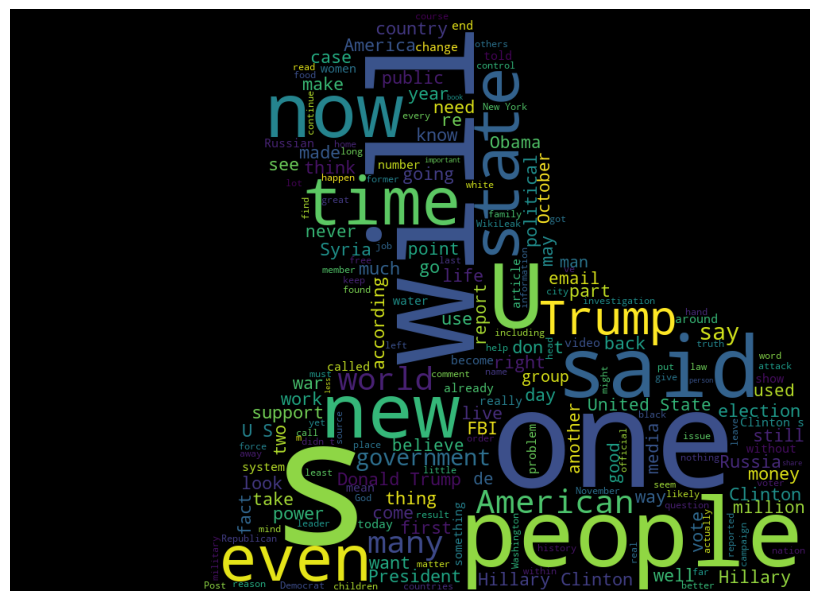

In [12]:
wordcloud = WordCloud(width=1920,height=1080,mask=wordcld_mask).generate(real_text)
fig=plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [13]:
fake_text = " ".join(fake_data["article"].tolist())

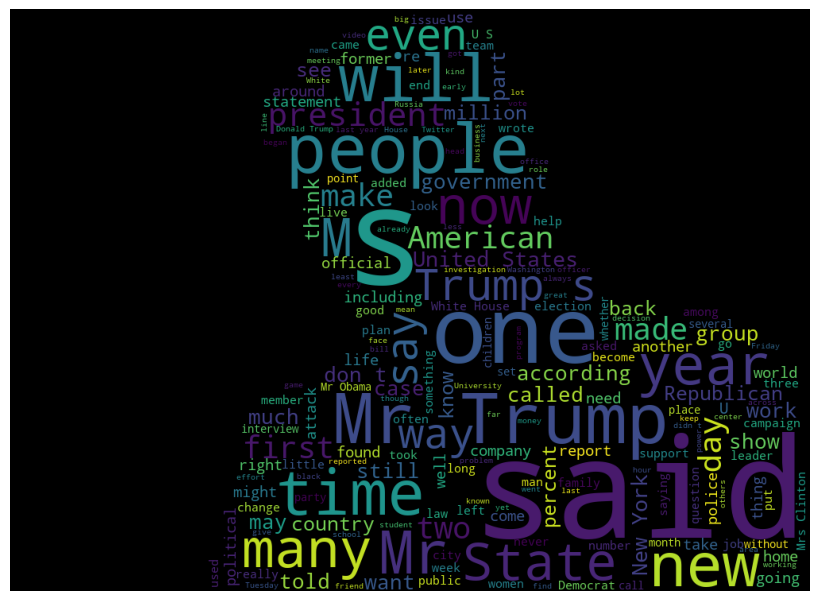

In [14]:
wordcloud = WordCloud(width=1920,height=1080,mask=wordcld_mask).generate(fake_text)
fig=plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Compile Data

In [10]:
final_data = pd.concat([fake_data,real_data])

In [11]:
final_data.head()

,label,article
24000,Fake,Applying to college is onerous enough. Asking ...
24001,Fake,"From Amsterdam to New York, London to Havana, ..."
24002,Fake,CNN has published a stinging fact check of the...
24003,Fake,Scientists say they may have found a sort of m...
24004,Fake,Google’s antitrust problems in Europe are abou...


In [12]:
final_data.isnull().sum()

label      0
article    0
dtype: int64

In [14]:
final_data['label'] = final_data['label'].map({'Real':1, 'Fake':0})

In [15]:
final_data.sample(5)

,label,article
24558,1,Arrow stars on Oliver and Felicity's future
24764,0,ROME (AP) — Jim Harbaugh didn’t have a grea...
24432,1,Top Chef season 15 winner is Joe Flamm
24635,0,"The news can seem grim. Refugee crises, extrem..."
24456,1,'13 Reasons Why': Katherine Langford says good...


Prepare BERT

In [16]:
max_len = 100
data_text = final_data["article"]
data_label = final_data["label"]

In [17]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [18]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state =42)

In [20]:
def tokenize(X):

    X = bert_tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
    )
    return X

In [21]:
X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

2023-09-29 02:50:38.259854: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-09-29 02:50:38.259989: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-09-29 02:50:38.260264: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-09-29 02:50:38.260607: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-29 02:50:38.261495: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
maxlen = 100

Create BERT Model

In [23]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [24]:
def create_model():
    dropout_rate=0.2
    input_ids=Input(shape=(maxlen,),dtype=tf.int32)
    input_mask=Input(shape=(maxlen,),dtype=tf.int32)
    bert_layer=bert_model([input_ids,input_mask])[1]
    x=Dropout(0.5)(bert_layer)
    x=Dense(64,activation="tanh")(x)
    x=Dropout(0.2)(x)
    x=Dense(1,activation="sigmoid")(x)
    model = Model(inputs=[input_ids, input_mask], outputs=x)
    return model

In [25]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 100, 7                                           
                             68),                                                             

In [26]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-05,
    decay_steps=10000,
    decay_rate=0.01)

In [27]:
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')

In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=50,baseline=0.4,min_delta=0.0001,restore_best_weights=False)

Train Model

In [29]:
history = model.fit(x = {'input_1':X_train_token['input_ids'],'input_2':X_train_token['attention_mask']}, y = Y_train, epochs=4, validation_split = 0.2, batch_size = 30, callbacks=[callback])

Epoch 1/4


2023-09-29 02:51:06.994651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - ETA: 0s - loss: 0.5234 - accuracy: 0.7617

2023-09-29 02:57:13.639644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 386s 9s/step - loss: 0.5234 - accuracy: 0.7617 - val_loss: 0.2247 - val_accuracy: 0.9688
Epoch 2/4
 7/43 [===>..........................] - ETA: 6:59 - loss: 0.2645 - accuracy: 0.9429

KeyboardInterrupt: 

Visualize Accuracy & Loss

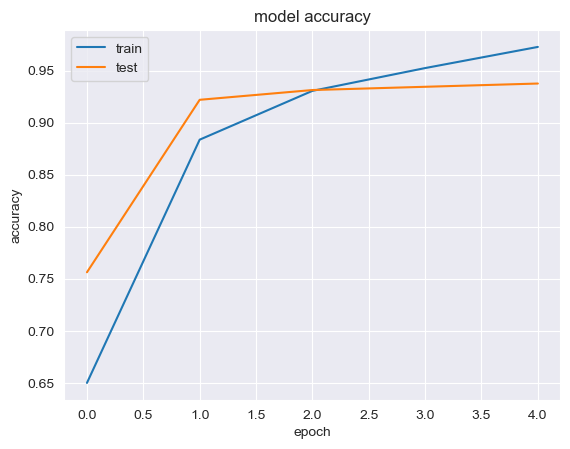

In [30]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

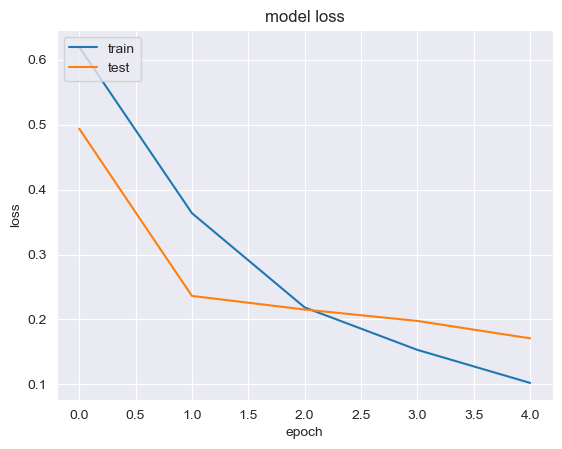

In [31]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
y_pred = np.where(model.predict({ 'input_1' : X_test_token['input_ids'] , 'input_2' : X_test_token['attention_mask']}) >=0.5,1,0)

2023-09-29 02:02:02.349879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 23s 1s/step


Confusion Matrix

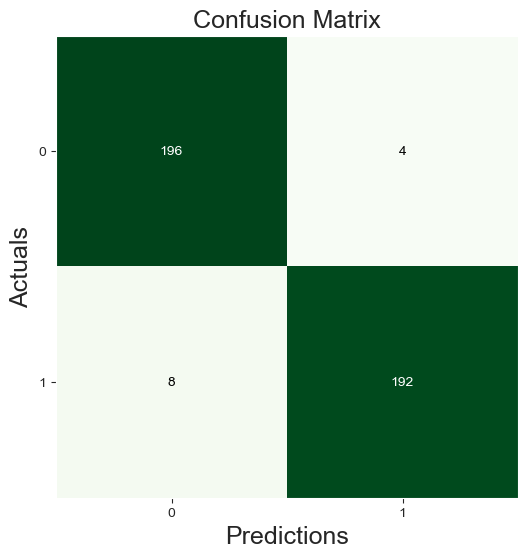

In [33]:
from mlxtend.plotting import plot_confusion_matrix
conf_matrix = confusion_matrix(Y_test,y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [34]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       200
           1       0.98      0.96      0.97       200

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400
